In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/facial-keypoints-detection

[Errno 2] No such file or directory: '/content/drive/My Drive/facial-keypoints-detection'
/content


In [3]:
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data.csv')

In [5]:
df

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2135,67.180378,35.816373,33.239956,34.921932,59.347973,37.000904,72.667896,37.097600,39.404349,36.589944,24.972418,36.348203,56.402841,31.171586,80.709708,30.595738,38.187845,30.595738,17.275454,29.534964,45.805390,60.065396,64.397610,73.248393,35.446431,74.014748,48.708626,76.760852,48.559612,77.335618,191 191 191 190 189 185 184 120 54 34 19 24 31...
2136,65.724490,36.301020,25.377551,37.311224,58.530612,37.739796,74.448980,37.525510,33.551020,38.107143,15.979592,38.076531,56.941270,29.605102,81.314059,30.754762,35.059410,29.566780,8.578912,32.096032,53.649433,62.472789,66.928121,79.229046,28.015377,81.151722,48.771976,81.816774,49.287271,82.871156,19 19 19 18 13 7 3 4 3 1 3 9 11 12 12 13 10 9 ...
2137,68.430866,38.651975,28.895857,37.617027,61.659350,40.100902,75.586792,40.219182,37.665118,39.087245,21.621652,39.095524,62.388142,32.089787,85.829396,38.724104,42.595762,30.541779,11.230184,34.485512,53.318891,63.289576,68.864397,77.495823,22.013981,77.368995,49.180628,79.043130,47.176739,89.544522,31 40 47 31 54 58 63 100 86 80 82 75 79 86 90 ...
2138,64.152180,30.691592,27.000898,40.868082,56.505624,34.126963,73.436776,28.556335,34.746122,40.506939,16.850204,44.409861,51.463469,27.161327,77.354898,19.562755,34.135510,32.830102,9.731633,41.152347,54.075935,59.735799,73.730743,70.273886,38.777143,80.684286,58.042857,79.301429,58.611086,80.355543,7 1 5 1 3 20 12 0 5 8 6 18 13 9 8 12 12 11 4 8...


In [6]:
df['Image'] = df['Image'].apply(lambda x: np.fromstring(x, dtype= int, sep = ' ').reshape(96,96))

In [7]:
df['Image'][0].shape

(96, 96)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [9]:
i = np.random.randint(1, len(df))

In [10]:
import copy
df_copy = copy.copy(df)

In [11]:
columns = df_copy.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [12]:
df_copy['Image'] = df_copy['Image'].apply(lambda x: np.flip(x, axis = 1))
for i in range(len(columns)):
  if i%2 == 0:
    df_copy[columns[i]] = df_copy[columns[i]].apply(lambda x: 96. - float(x) )

In [13]:
augmented_df = np.concatenate((df,df_copy))

In [14]:
import random

df_copy = copy.copy(df)
df_copy['Image'] = df['Image'].apply(lambda x:np.clip(random.uniform(1, 2)* x,0.0, 255.0))
augmented_df = np.concatenate((augmented_df,df_copy))
augmented_df.shape

(6420, 31)

In [15]:
df_copy = copy.copy(df)
df_copy['Image'] = df_copy['Image'].apply(lambda x: np.flip(x, axis = 0))

for i in range(len(columns)):
  if i%2 == 1:
    df_copy[columns[i]] = df_copy[columns[i]].apply(lambda x: 96. - float(x) )

In [16]:
img = augmented_df[:,30]
img = img/255.
X = np.empty((len(img), 96, 96, 1))
for i in range(len(img)):
  X[i,]= np.expand_dims(img[i], axis = 2)
X = np.asarray(X).astype(np.float32)
X.shape

(6420, 96, 96, 1)

In [17]:
y = augmented_df[:,:30]
y = np.asarray(y).astype(np.float32)
y.shape

(6420, 30)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1)

In [19]:
def res_block(X, filter, stage):
  #Convolutional_block

  X_copy = X

  f1 , f2, f3 = filter
  #Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  #Short path

  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  #ADD

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  #Identity Block 1

  X_copy = X


  #Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  #ADD

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  #Identity Block 2

  X_copy = X


  #Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  #ADD

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [20]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# 1 - stage
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2 - stage
X = res_block(X, filter= [64,64,256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128,128,512], stage= 3)


# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)


model = Model( inputs= X_input, outputs = X)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
______________________________________________________________________________________________

In [21]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="mean_squared_error",optimizer= adam , metrics = ['accuracy'])

In [22]:
checkpointer = ModelCheckpoint(filepath="weights_keypoint.hdf5", verbose=1, save_best_only=True)

In [23]:
history = model.fit(X_train, y_train, batch_size = 32, epochs= 100, validation_split = 0.05, callbacks=[checkpointer])

Epoch 1/100
172/172 [==============================] - 39s 26ms/step - loss: 675.5027 - accuracy: 0.3143 - val_loss: 661.5995 - val_accuracy: 0.6678

Epoch 00001: val_loss improved from inf to 661.59955, saving model to weights_keypoint.hdf5
Epoch 2/100
172/172 [==============================] - 3s 20ms/step - loss: 103.6915 - accuracy: 0.5994 - val_loss: 282.4550 - val_accuracy: 0.6678

Epoch 00002: val_loss improved from 661.59955 to 282.45499, saving model to weights_keypoint.hdf5
Epoch 3/100
172/172 [==============================] - 4s 20ms/step - loss: 67.2158 - accuracy: 0.6091 - val_loss: 173.4577 - val_accuracy: 0.6678

Epoch 00003: val_loss improved from 282.45499 to 173.45775, saving model to weights_keypoint.hdf5
Epoch 4/100
172/172 [==============================] - 4s 21ms/step - loss: 46.7438 - accuracy: 0.5963 - val_loss: 92.7012 - val_accuracy: 0.6713

Epoch 00004: val_loss improved from 173.45775 to 92.70116, saving model to weights_keypoint.hdf5
Epoch 5/100
172/172 [

In [24]:
model_json = model.to_json()
with open("detection.json","w") as json_file:
  json_file.write(model_json)


In [25]:
with open('detection.json', 'r') as json_file:
    json_savedModel= json_file.read()
#load the model architecture 
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights_keypoint.hdf5')
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="mean_squared_error",optimizer= adam , metrics = ['accuracy'])

In [26]:
result = model.evaluate(X_test,y_test)
print("Accuracy : {}".format(result[1]))

21/21 [==============================] - 1s 12ms/step - loss: 52.6757 - accuracy: 0.7464
Accuracy : 0.7383177280426025


In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

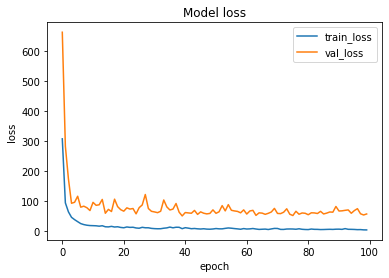

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

In [29]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/icml_face_data.csv')

In [30]:
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3,2,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...


In [31]:
def string2array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [32]:
def resize(x):
  img = x.reshape(48,48)
  return cv2.resize(img,dsize=(96, 96), interpolation=cv2.INTER_CUBIC)

In [33]:
df[' pixels'] = df[' pixels'].apply(lambda x: string2array(x))


In [34]:
df[' pixels'] = df[' pixels'].apply(lambda x: resize(x))

In [35]:
df.head()

,emotion,pixels
0,0,"[[69.316925, 73.03865, 79.13719, 84.17186, 85...."
1,0,"[[151.09435, 150.91393, 150.65791, 148.96367, ..."
2,2,"[[23.061905, 25.50914, 29.47847, 33.99843, 36...."
3,2,"[[20.083221, 19.079437, 17.398712, 17.158691, ..."
4,3,"[[76.26172, 76.54747, 77.001785, 77.7672, 78.4..."


In [36]:
df.shape

(24568, 2)

In [37]:
df.isnull().sum()

emotion    0
 pixels    0
dtype: int64

In [38]:
label_to_text = {0:'anger', 1:'disgust', 2:'sad', 3:'happiness', 4: 'surprise'}

Text(0.5, 1.0, 'Number of images per emotion')

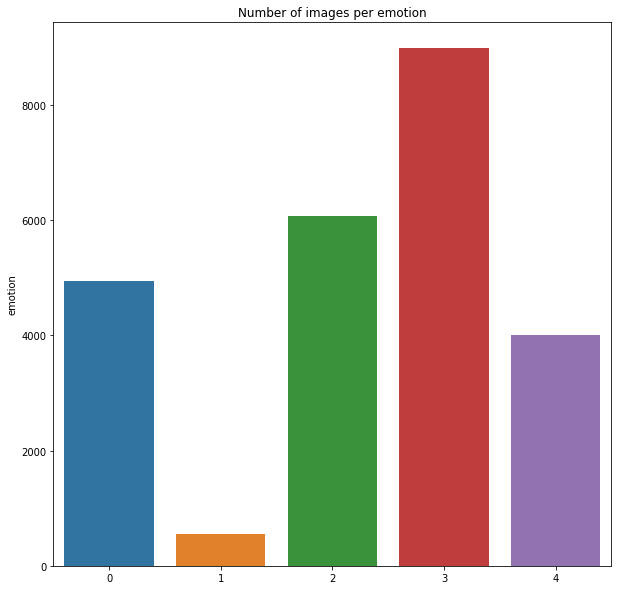

In [39]:
plt.figure(figsize=(10,10))
sns.barplot(x = df.emotion.value_counts().index, y = df.emotion.value_counts() )
plt.title('Number of images per emotion')


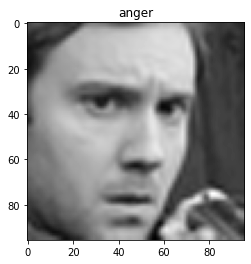

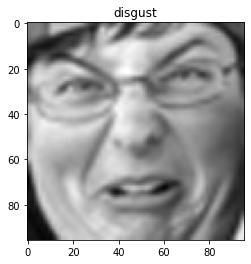

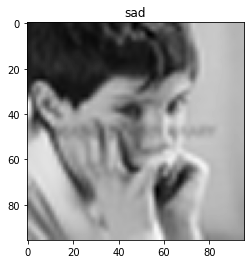

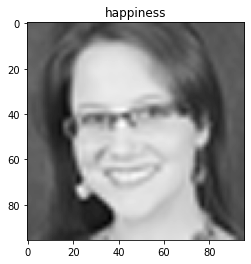

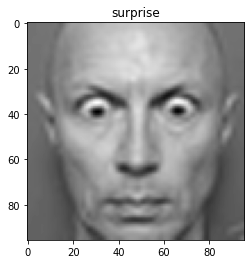

In [40]:
emotions = [0,1,2,3,4]

for i in emotions:
  data = df[df['emotion'] == i][:1]
  img = data[' pixels'].item()
  img = img.reshape(96,96)
  plt.figure()
  plt.title(label_to_text[i])
  plt.imshow(img, cmap= 'gray')

In [41]:
from keras.utils import to_categorical

X = df[' pixels']
y = to_categorical(df['emotion'])

X = np.stack(X, axis=0)
X = X.reshape(24568,96,96,1)

print(X.shape, y.shape)

(24568, 96, 96, 1) (24568, 5)


In [42]:
from sklearn.model_selection import train_test_split

X_train ,X_Test, y_train, y_Test= train_test_split(X,y,test_size = 0.1, shuffle = True)
X_val,X_Test, y_val,y_Test = train_test_split(X_Test,y_Test, test_size = 0.5, shuffle = True)


In [43]:
print(X_val.shape, y_val.shape)

(1228, 96, 96, 1) (1228, 5)


In [44]:
X_train = X_train/255
X_val   = X_val /255
X_Test  = X_Test/255

In [45]:
train_datagen = ImageDataGenerator(
rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode = "nearest"
)


## BUILD AND TRAIN DEEP LEARNING MODEL

In [46]:
input_shape = (96,96,1)

#Input tensor shape
X_input = Input(input_shape)

#Zero-padding

X = ZeroPadding2D((3,3))(X_input)

# 1 - stage
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2- stage
X = res_block(X, filter= [64,64,256], stage= 2)

# 3- stage
X = res_block(X, filter= [128,128,512], stage= 3)
X = AveragePooling2D((4,4), name = 'Averagea_Pooling')(X)

#Final layer

X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)


model_e = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model_e.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [47]:
model_e.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [48]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
checkpointer = ModelCheckpoint(filepath="weights_emotions.hdf5", verbose=1, save_best_only=True)

In [49]:
history = model_e.fit(train_datagen.flow(X_train, y_train, batch_size=64),
	validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 64,
	epochs= 50, callbacks=[checkpointer, earlystopping])

Epoch 1/50
345/345 [==============================] - 25s 65ms/step - loss: 1.5608 - accuracy: 0.3980 - val_loss: 1.4565 - val_accuracy: 0.3982

Epoch 00001: val_loss improved from inf to 1.45649, saving model to weights_emotions.hdf5
Epoch 2/50
345/345 [==============================] - 21s 61ms/step - loss: 0.9622 - accuracy: 0.6197 - val_loss: 1.0015 - val_accuracy: 0.5969

Epoch 00002: val_loss improved from 1.45649 to 1.00147, saving model to weights_emotions.hdf5
Epoch 3/50
345/345 [==============================] - 20s 59ms/step - loss: 0.8230 - accuracy: 0.6766 - val_loss: 0.8676 - val_accuracy: 0.6539

Epoch 00003: val_loss improved from 1.00147 to 0.86763, saving model to weights_emotions.hdf5
Epoch 4/50
345/345 [==============================] - 21s 60ms/step - loss: 0.7537 - accuracy: 0.7120 - val_loss: 0.7440 - val_accuracy: 0.7207

Epoch 00004: val_loss improved from 0.86763 to 0.74395, saving model to weights_emotions.hdf5
Epoch 5/50
345/345 [============================

In [50]:
model_json = model_e.to_json()
with open("emotion.json","w") as json_file:
  json_file.write(model_json)

In [51]:
with open('emotion.json', 'r') as json_file:
    json_savedModel= json_file.read()
#load the model architecture 
model_e = tf.keras.models.model_from_json(json_savedModel)
model_e.load_weights('weights_emotions.hdf5')
model_e.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [52]:
score = model_e.evaluate(X_Test, y_Test)
print('Test Accuracy: {}'.format(score[1]))

39/39 [==============================] - 1s 10ms/step - loss: 0.6592 - accuracy: 0.7649
Test Accuracy: 0.7811228632926941


In [53]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [54]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

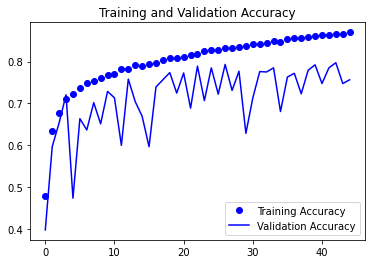

In [55]:
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

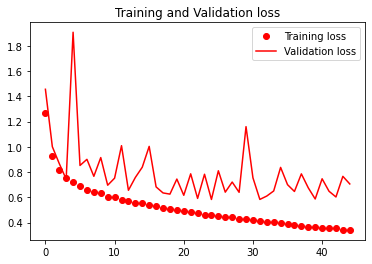

In [56]:
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

In [57]:
#predicted_classes = model.predict_classes(X_test)
predicted_classes = np.argmax(model_e.predict(X_Test), axis=-1)
y_true = np.argmax(y_Test, axis=-1)

In [58]:
y_true.shape

(1229,)

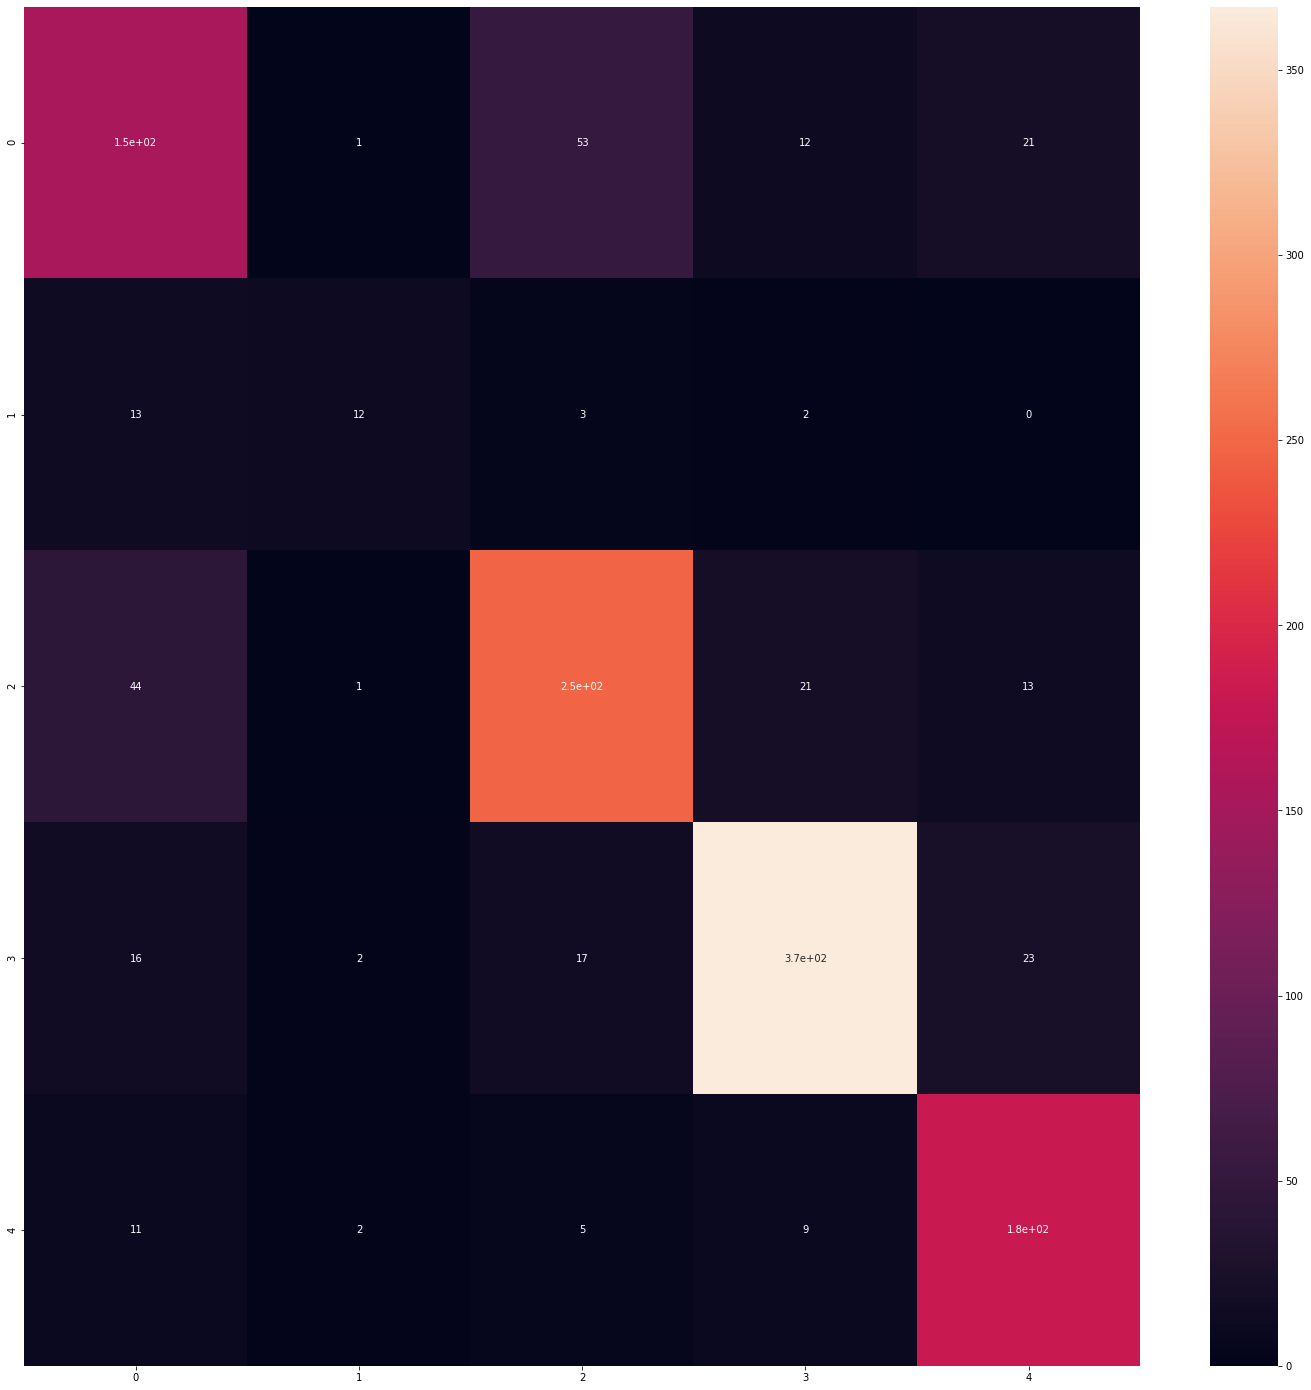

In [59]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (25, 25))
sns.heatmap(cm, annot = True)

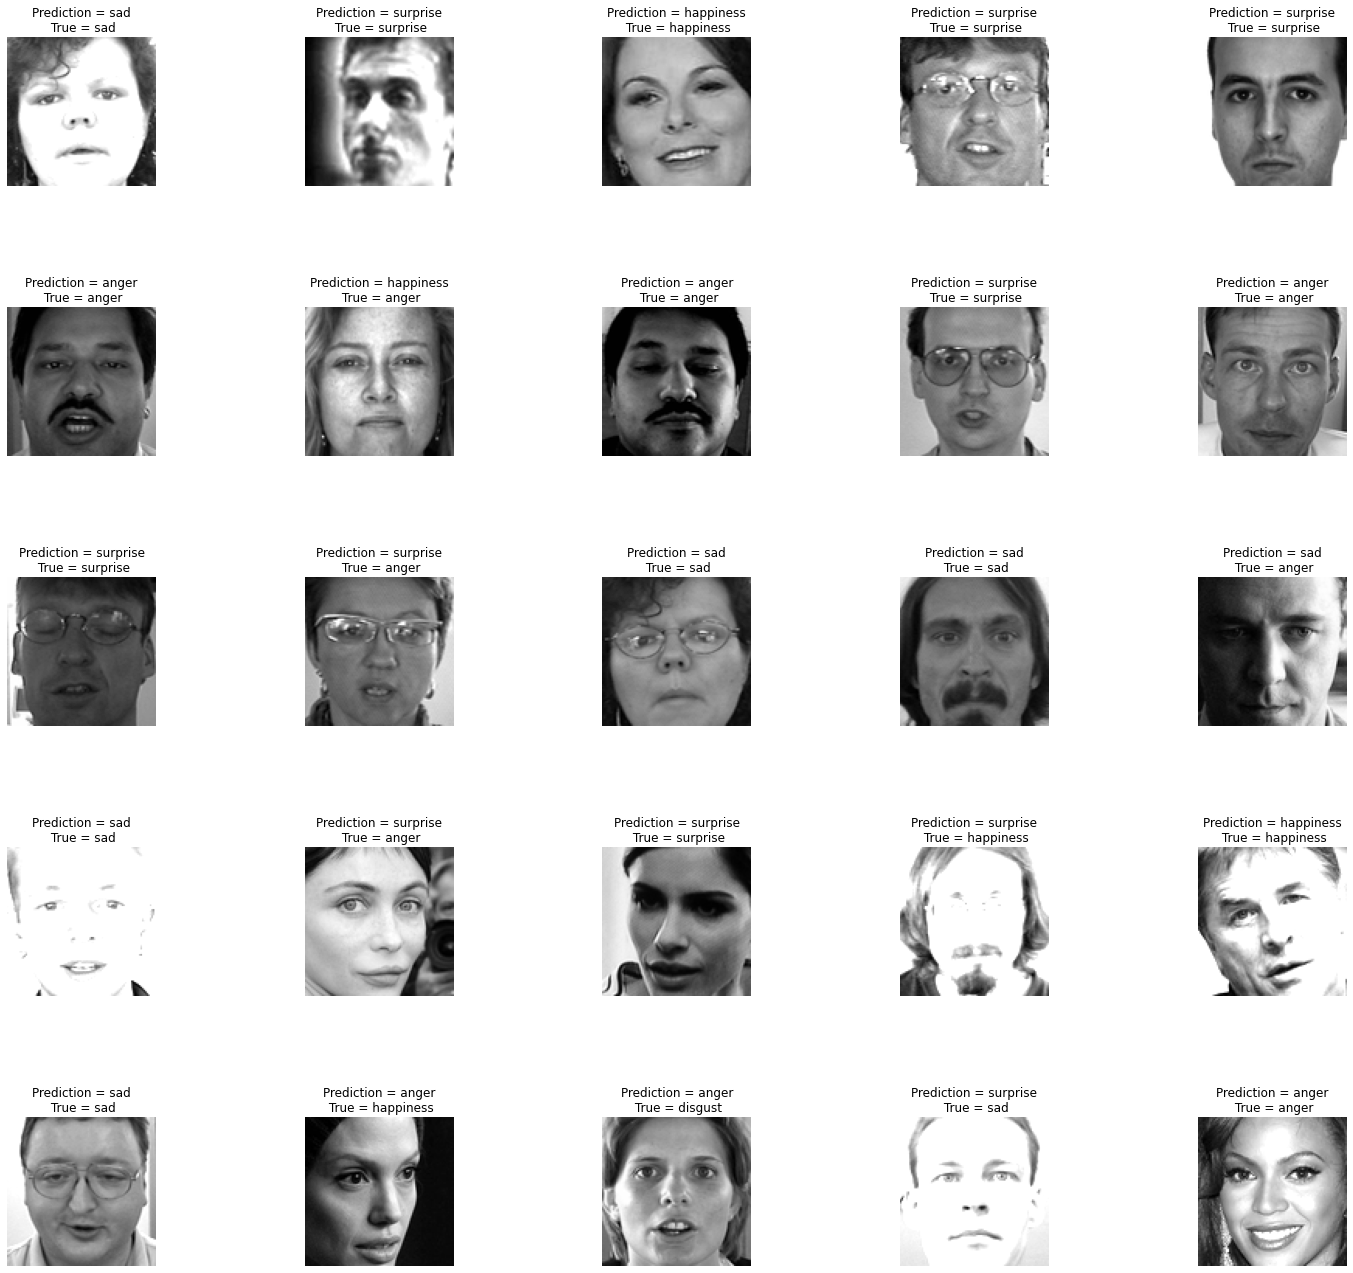

In [60]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (24, 24))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(X_test[i].reshape(96,96), cmap = 'gray')
    axes[i].set_title('Prediction = {}\n True = {}'.format(label_to_text[predicted_classes[i]], label_to_text[y_true[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1)    

# USING THE BEST MODEL:

In [61]:
def predict(X_test):
  df_predict = model.predict(X_test)
  df_emotion = np.argmax(model_e.predict(X_test), axis=-1)
  df_emotion = np.expand_dims(df_emotion, axis = 1)
  df_predict= pd.DataFrame(df_predict, columns= columns)
  df_predict['emotion'] = df_emotion

  return df_predict

In [62]:
df_predict = predict(X_test)

In [63]:
df_predict.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,emotion
0,65.507240,37.186630,28.051970,40.657139,58.736969,38.000137,72.873421,37.928486,34.575169,40.032230,20.793247,42.525764,56.238300,28.286032,78.429497,29.355751,37.011135,30.444633,13.727346,34.836426,48.811855,48.622284,65.430511,74.486572,34.567425,78.100136,49.606964,66.675713,50.534771,82.522690,4
1,64.674202,37.622555,30.230850,37.834721,57.155243,38.242294,72.487946,38.264488,36.845585,38.462437,22.583590,38.674023,53.035484,30.088419,77.979546,31.301685,39.247066,31.100582,17.008673,31.625000,43.553505,57.645123,61.328026,78.156120,33.848194,78.204079,46.200306,74.697136,46.411636,80.139175,2
2,29.330156,38.656208,62.626202,34.500759,35.627754,38.523537,22.854593,40.189720,56.528011,36.027039,68.976181,34.459370,37.607300,29.013554,15.459114,33.095871,51.561420,27.245960,74.363213,26.009323,48.654472,54.228134,38.357719,74.865540,66.123840,72.182892,51.655659,69.313484,52.907814,82.517845,3
3,69.525429,31.206585,27.908144,32.116646,62.765926,31.621950,76.328163,32.360222,34.685478,32.085194,21.109512,33.409267,60.613274,20.071770,83.816582,22.797626,39.569599,21.566341,12.877598,25.627745,50.477325,48.136463,65.740456,72.974068,35.401134,72.264320,49.540516,64.798645,50.378494,81.487503,4
4,67.059479,37.844036,28.431580,38.102406,58.336884,38.754684,76.417686,38.982590,36.427837,38.955719,19.305595,39.245880,54.088417,30.067039,83.260399,31.191792,38.493191,30.625471,12.782077,30.769329,44.610077,61.114643,64.408066,78.327339,31.088648,78.598137,46.596485,76.528214,46.820599,84.991310,2


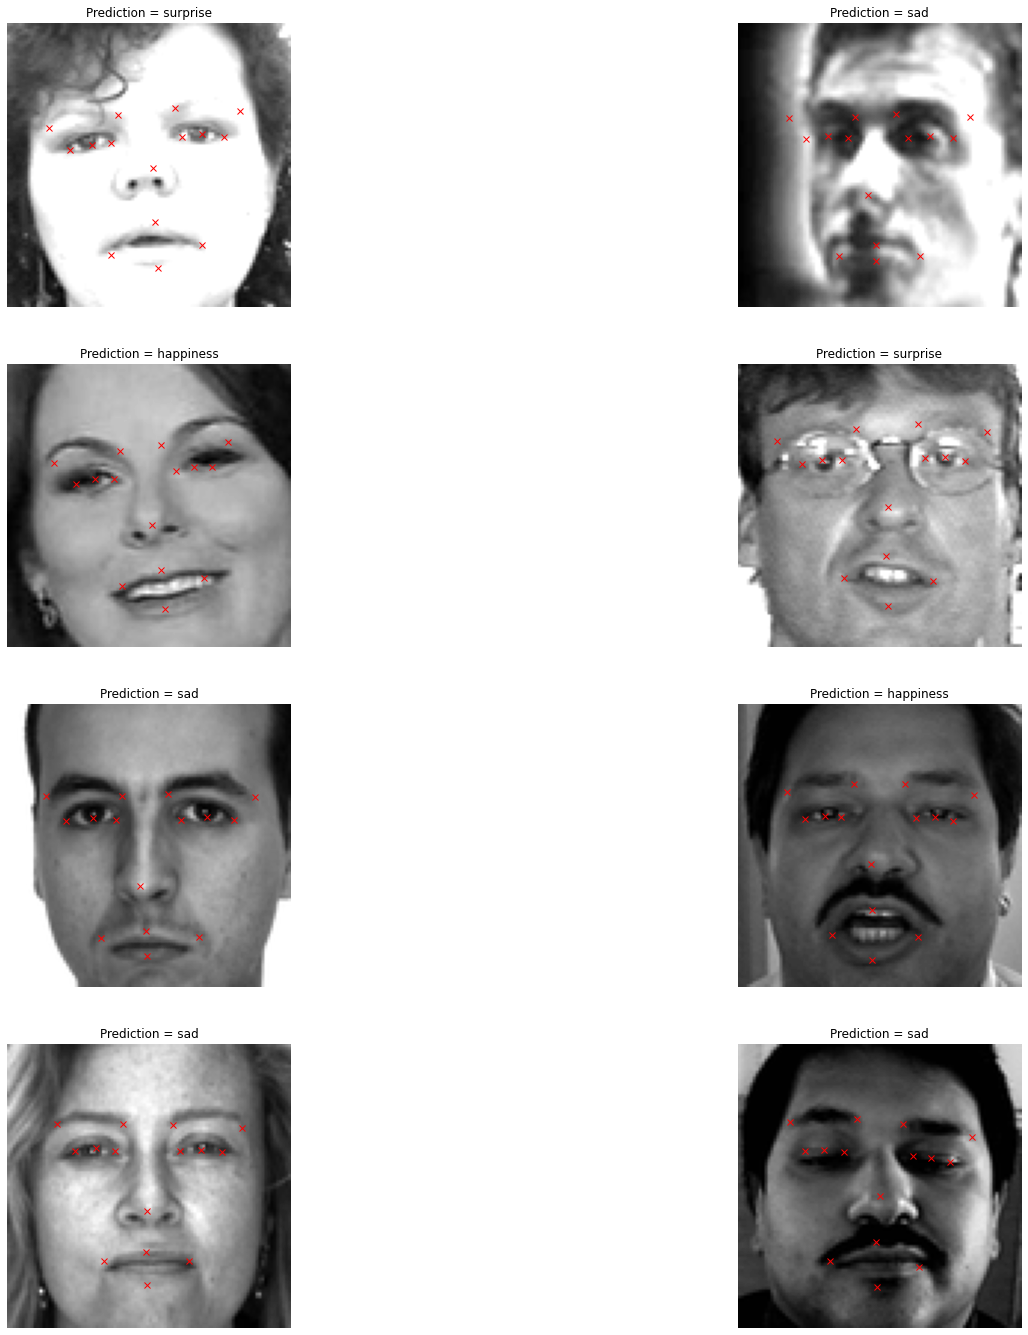

In [64]:
#Plotting the test images and their predicted keypoints and emotions

fig, axes = plt.subplots(4, 2, figsize = (24, 24))
axes = axes.ravel()

for i in range(8):

    axes[i].imshow(X_test[i].squeeze(),cmap='gray')
    axes[i].set_title('Prediction = {}'.format(label_to_text[df_predict['emotion'][i]]))
    axes[i].axis('off')
    for j in range(1,31,2):
            axes[i].plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')
            

In [65]:
from PIL import Image, ImageOps

def grad_cam(img):

  #Covert the image to array of type float32
  img = np.asarray(img, dtype= np.float32)

  #Reshape the image from (96,96,1) to (1,96,96,1))
  img = img.reshape(-1,96,96,1)
  img_scaled = img / 255

  #Name of the layers we added to the base_model, you can find this in the model summaty
  #Every-time you run the model, check the summary, as the name would change or to avoid it 
  #you can add name to each layer
  classification_layers = ["Averagea_Pooling","Dense_final"]

  #Last convolutional layer in the base mdel, this woun't change as name has been already assigned to it.
  final_conv = model_e.get_layer("res_3_identity_2_c")

  #Create a model with original model input as input and the last conv_layer as the output
  final_conv_model = keras.Model(model_e.inputs, final_conv.output)

  #Then,we create the input for classification layer, which is the output of last conv layer
  #In our case, output produced by the conv layer is of the shape (1,2,2,1024) 
  #Since, the classification input needs the features as input, we ignore the batch dimension

  classification_input = keras.Input(shape=final_conv.output.shape[1:])

  # We iterate through the classification layers, to get the final layer and then, append 
  #the layer as the output layer to the classification model.
  temp = classification_input
  for layer in classification_layers:
      temp = model_e.get_layer(layer)(temp)
  classification_model = keras.Model(classification_input, temp)


  #We use gradient tape to monitor the 'final_conv_output' to retrive the gradients
  #corresponding to the predicted class
  with tf.GradientTape() as tape:
      # Pass the image through the base model and get the feature map 
      final_conv_output = final_conv_model(img_scaled)

      #Assign gradient tape to monitor the conv_output
      tape.watch(final_conv_output)
      
      #Pass the feature map through the classification model and use argmax to get the 
      #index of the predicted class and then use the index to get the value produced by final
      #layer for that class

      prediction = classification_model(final_conv_output)

      predicted_class = tf.argmax(prediction[0][0][0])

      predicted_class_value = prediction[:,:,:,predicted_class]

  #Get the gradient corresponding to the predicted class based on feature map.
  #which is of shape (1,2,2,1024)
  gradient = tape.gradient(predicted_class_value, final_conv_output)

  #Since we need the filter values (1024), we reduce the other dimensions, 
  #hich would result in a shape of (1024,)
  gradient_channels = tf.reduce_mean(gradient, axis=(0, 1, 2))

  #We then convert the feature map produced by last conv layer(1,2,2,1024) to (1,2,2,1024)

  final_conv_output = final_conv_output.numpy()[0]

  gradient_channels = gradient_channels.numpy()

  #We multiply the filters in the feature map produced by final conv layer by the 
  #filter values that are used to get the predicted class. By doing this we inrease the
  #value of areas that helped in making the prediction and lower the vlaue of areas, that 
  #did not contribute towards the final prediction
  for i in range(gradient_channels.shape[-1]):
      final_conv_output[:, :, i] *= gradient_channels[i]

  #We take the mean accross the channels to get the feature map
  heatmap = np.mean(final_conv_output, axis=-1)

  #Normalizing the heat map between 0 and 1, to visualize it
  heatmap_normalized = np.maximum(heatmap, 0) / np.max(heatmap)

  # Rescaling and converting the type to int
  heatmap = np.uint8(255 * heatmap_normalized )


  # Create the colormap
  color_map = plt.cm.get_cmap('jet')

  # get only the rb features from the heatmap
  color_map = color_map(np.arange(256))[:, :3]
  heatmap = color_map[heatmap]

  #convert the array to image, resize the image and then convert to array
  heatmap = keras.preprocessing.image.array_to_img(heatmap)
  heatmap = heatmap.resize((96 ,96))
  heatmap = np.asarray(heatmap, dtype = np.float32)

  #take the value of heat map along any one channel as or image is of 1 channel
  heatmap = heatmap[:,:,2]
  heatmap = np.expand_dims(heatmap, axis = 2) 
 
  final_img =  (img[0]*0.4) + ((heatmap/255.0) * 0.8)
  final_img = keras.preprocessing.image.array_to_img(final_img)

  return final_img, heatmap_normalized

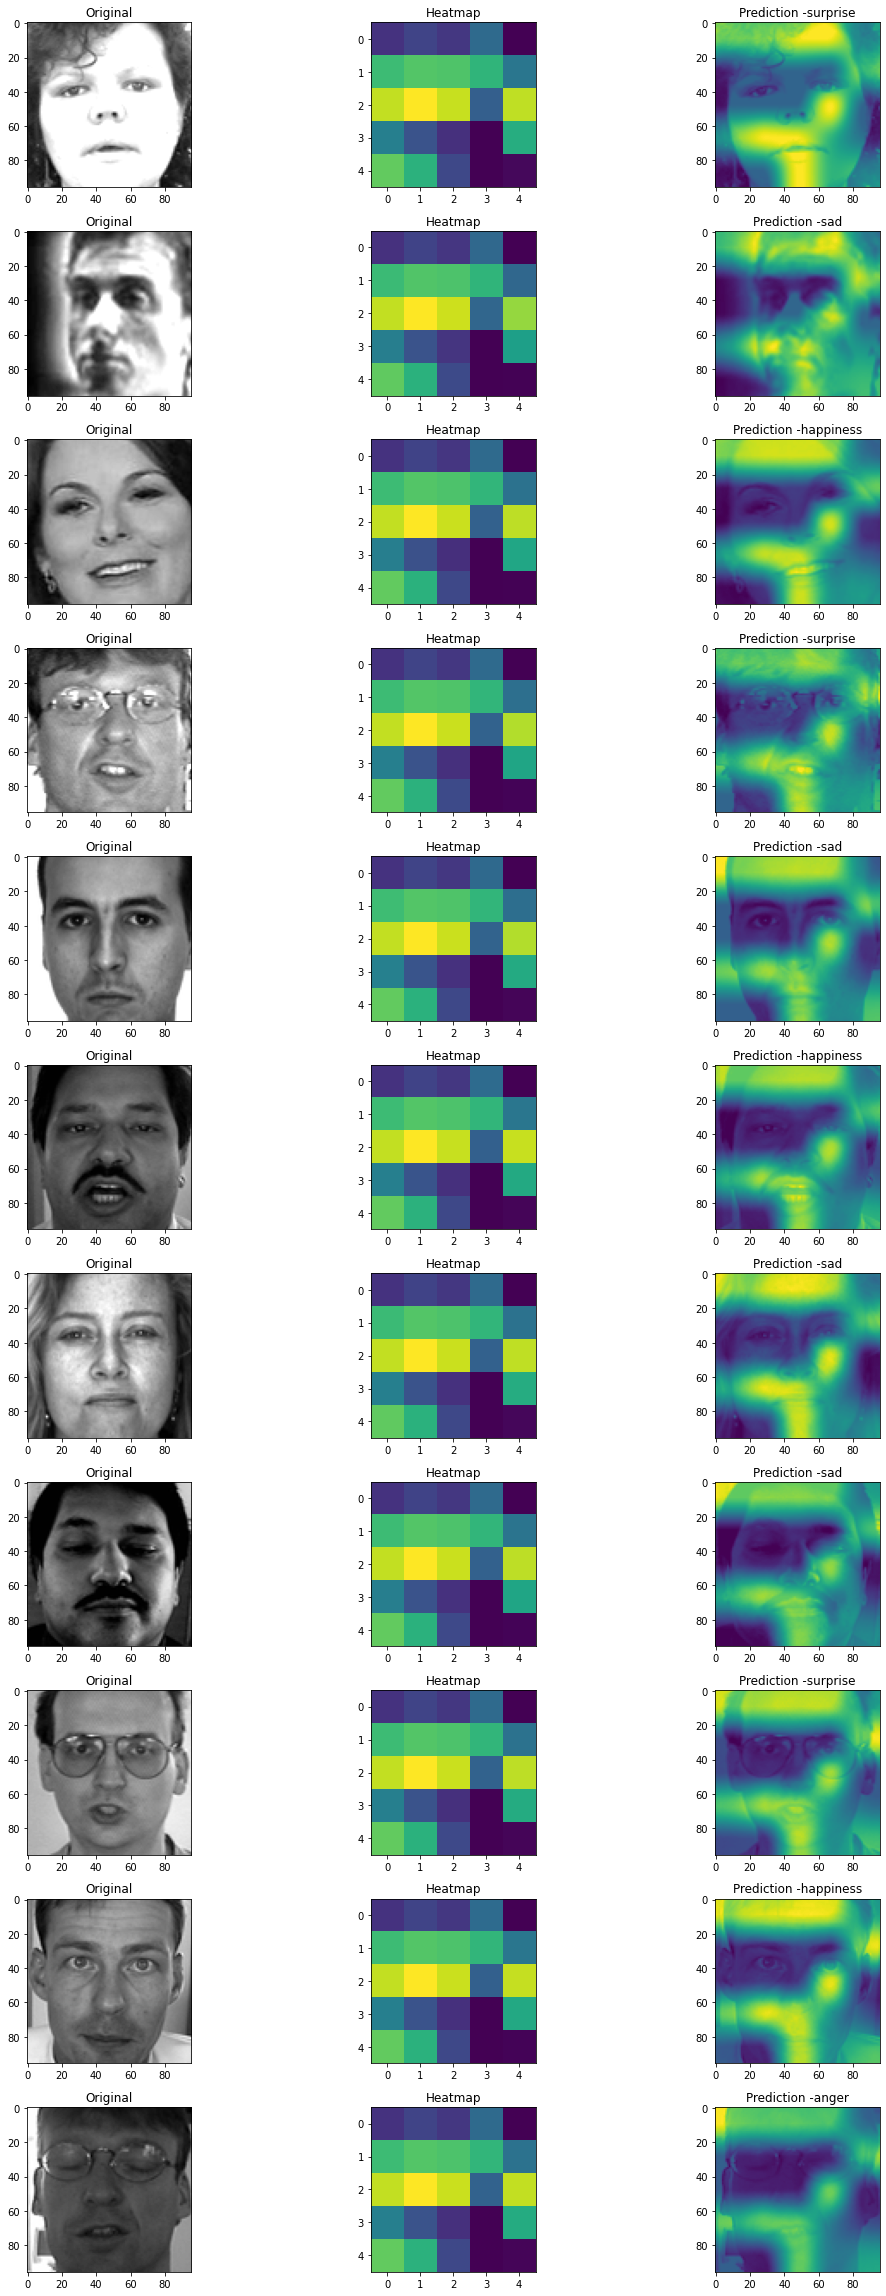

In [66]:
#Visualize the images in the dataset
import random
fig, axs = plt.subplots(11,3, figsize=(16,32))
count = 0
for i in range(11):
  #i = random.randint(0,len(X_test))
  gradcam, heatmap = grad_cam(X_test[i])
  axs[count][0].title.set_text("Original")
  axs[count][0].imshow(X_test[i].squeeze(),cmap = 'gray')
  axs[count][1].title.set_text("Heatmap") 
  axs[count][1].imshow(heatmap)
  axs[count][2].title.set_text("Prediction -" + label_to_text[df_predict['emotion'][i]]) 
  axs[count][2].imshow(gradcam)  
  count += 1

fig.tight_layout()